Видео лабораторной: https://youtu.be/A3LE-ZmtVGs

TG: https://t.me/data_science_news



---

In [ ]:
!pip install -U tensorflow-addons

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

print(tf.__version__)

2.8.0


## Первая часть (задача регрессии)
[Видео лабораторной](https://youtu.be/r-z1cjvpwBE)
- Кросс-валидация (cross-validation)
- Регуляризация (regularization)
- Целевая функция (objective function)
- Конструирование признаков (feature engineering)

## Вторая часть (задача регрессии)
- Конструирование признаков (feature engineering)
- Оценка модели (model assessment)
- Выбор модели (model selection)

# Дилема смещения-дисперсии (bias-variance trade-off)

Пусть задана MSE для оценки $\theta$: $\mathrm{MSE}(\theta)=E_\theta[(\hat{\theta}-\theta)^2]$

MSE для оценки $\hat{\theta}$ можно выразить как композицию смещения и дисперсии:

$\mathrm{MSE}(\theta)=E_\theta[(\hat{\theta}-\theta)^2]=...=E_\theta[(\hat{\theta}-E_\theta[\hat{\theta}])^2] + (E_\theta[\hat{\theta}]-\theta)^2=\mathrm{Var}_\theta(\hat{\theta})+\mathrm{Bias}(\hat{\theta},\theta)$

**В задаче регрессии**, вобщем виде для модели $y=f(x)+\epsilon$:

$E_{D,\epsilon}[y-\hat{f}(x;D)^2]=\mathrm{Var}_D(\hat{f}(x;D))+\mathrm{Bias}_D[\hat{f}(x;D)]^2+\sigma^2$

где

$\mathrm{Bias}_D[\hat{f}(x;D)]=E_D[\hat{f}(x;D)]-f(x)$

$\mathrm{Var}_D(\hat{f}(x;D))=E_D[(E_D[\hat{f}(x;D)]-\hat{f}(x;D))^2]$

$\epsilon$ - "величина ошибки" (noise), $E[\epsilon]=0$, $\mathrm{Var}(\epsilon)=\sigma^2$

$D=\{\{x_1,y_1\},\{x_2,y_2\},...,\{x_n,y_n\}\}$ - это выборка из совместного распределения $f_{X,Y}(x,y)$

**На наборе данных:** $\mathrm{MSE} = \frac{1}{N}\sum_{i=1}^n(y_i-\hat{y}_i)^2$

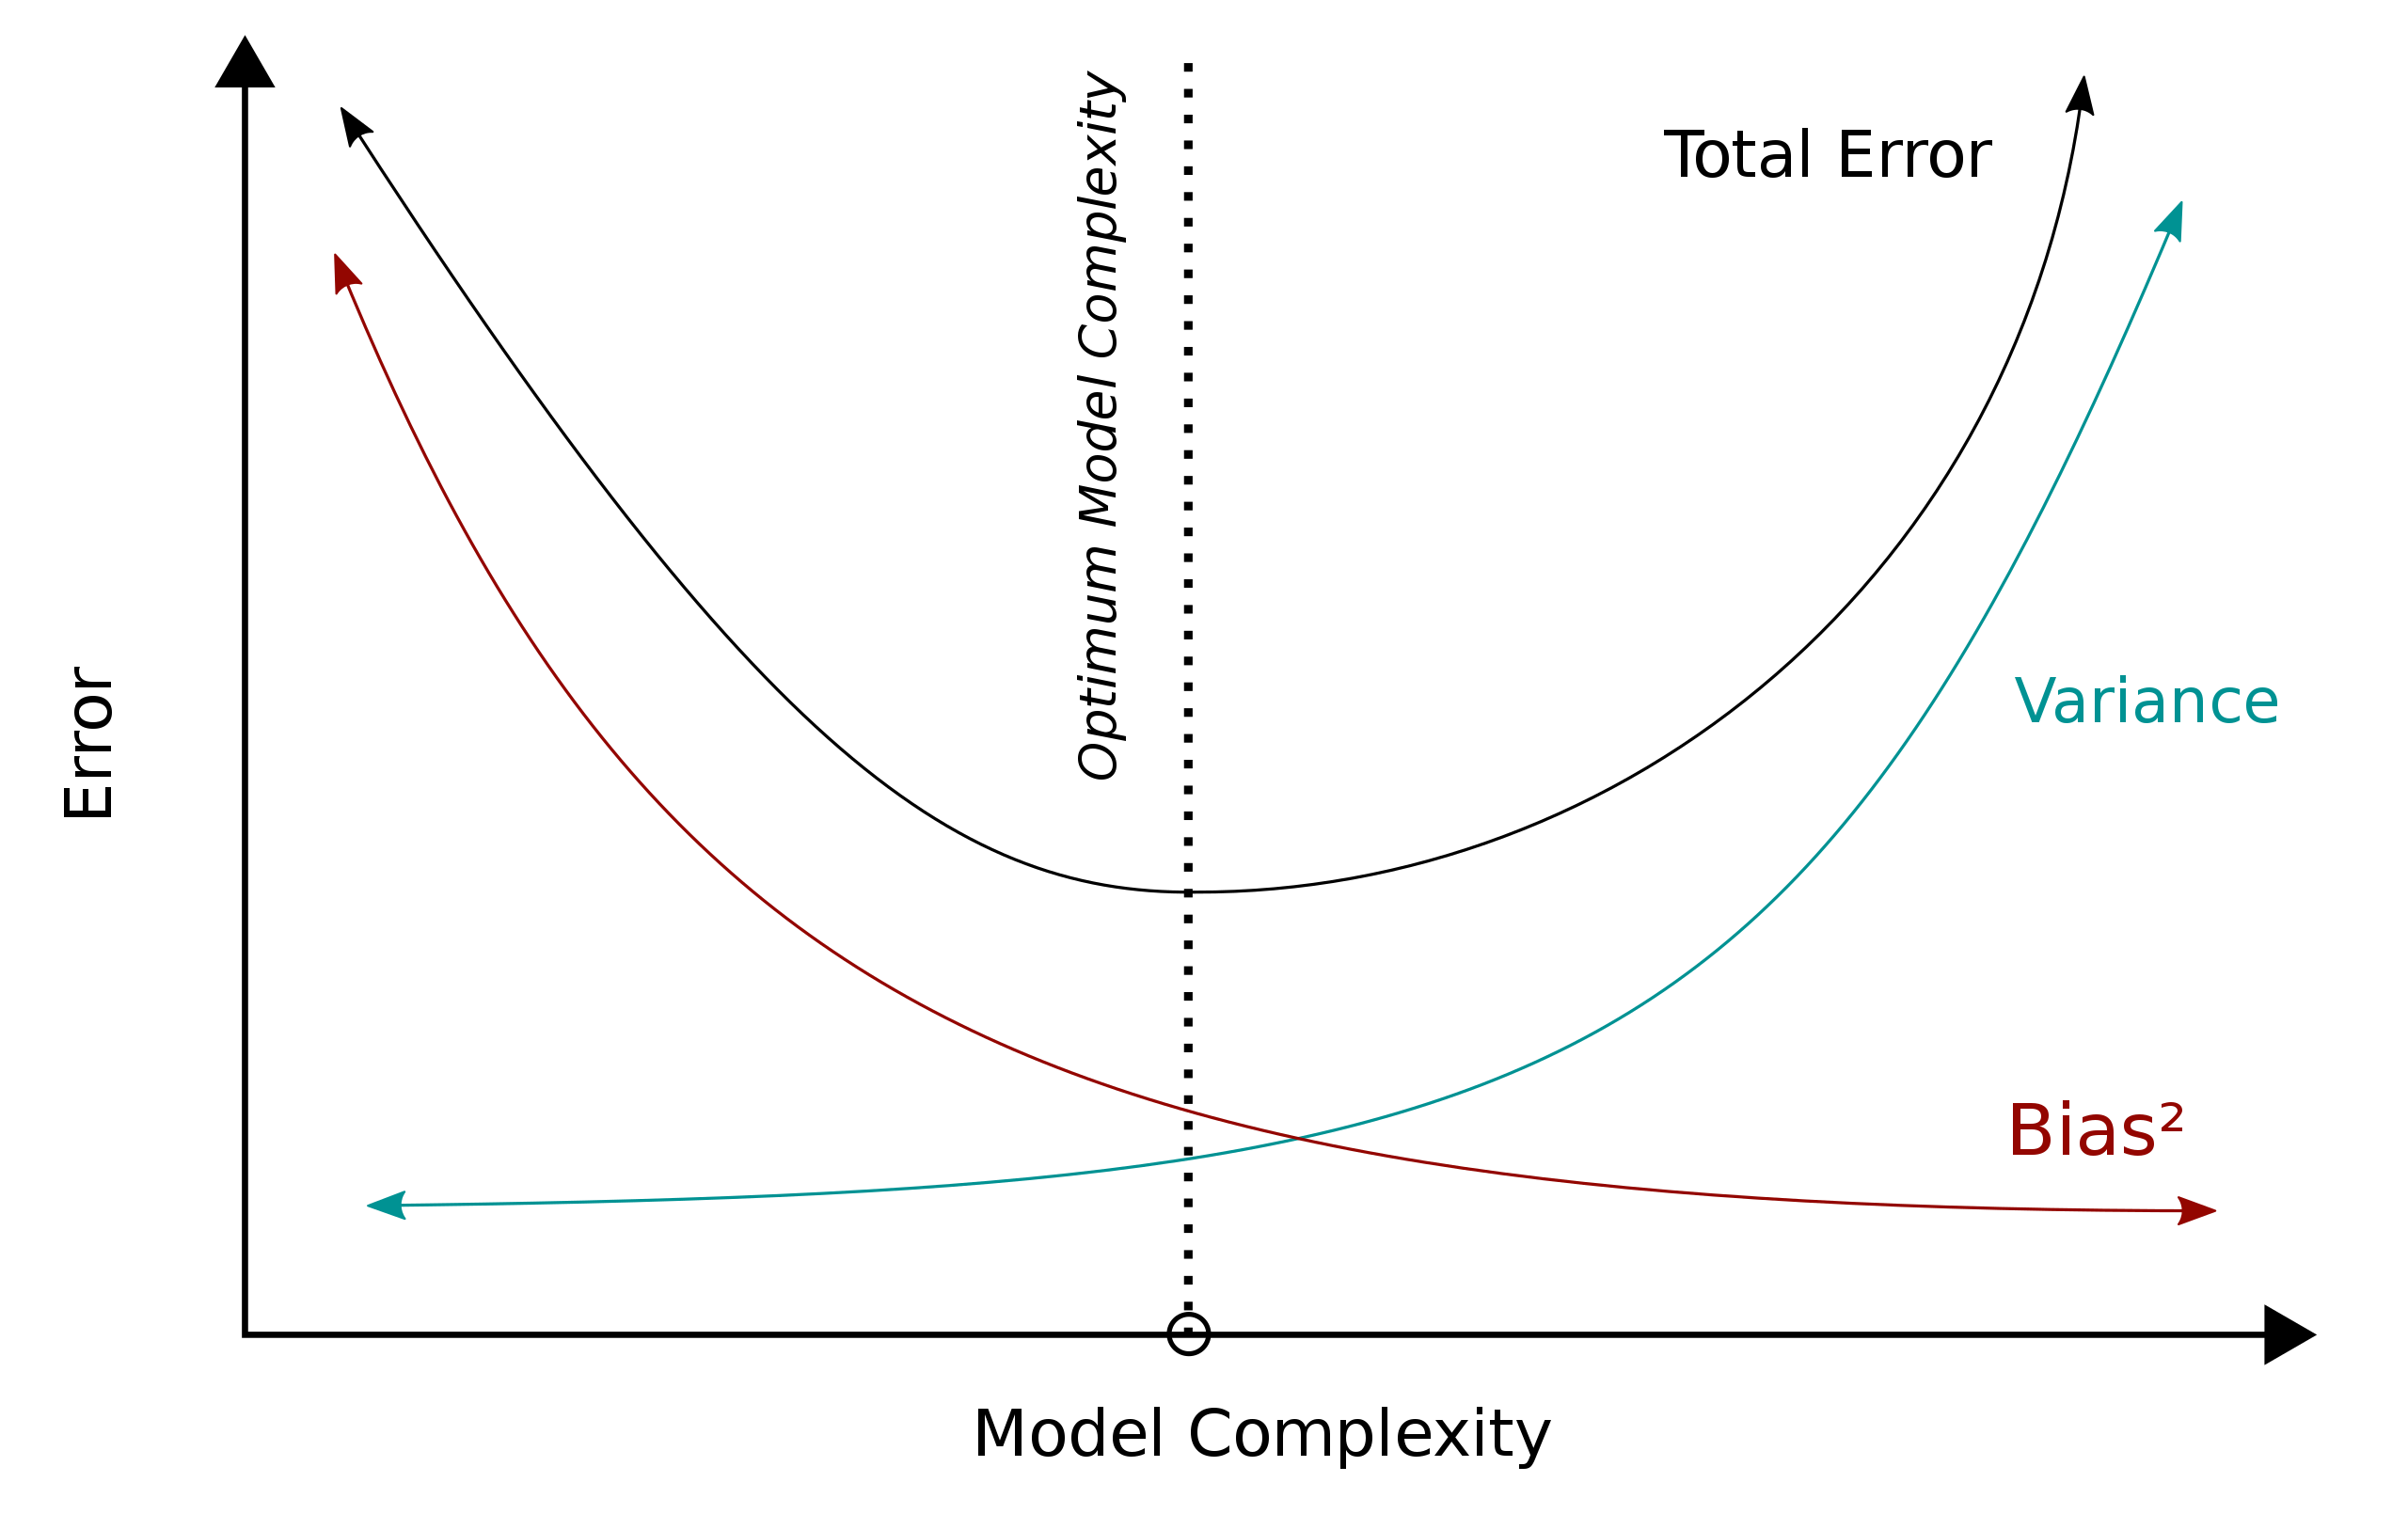

https://en.wikipedia.org/wiki/Bias–variance_tradeoff#/media/File:Bias_and_variance_contributing_to_total_error.svg

# Разведочный анализ данных

[Набор данных](https://github.com/nguyen-toan/ISLR/blob/master/dataset/Advertising.csv)

[Книга](http://www-bcf.usc.edu/~gareth/ISL/)

[Simple to Multiple and Polynomial Regression in R](https://www.kaggle.com/code/pranjalpandey12/simple-to-multiple-and-polynomial-regression-in-r/data)



In [ ]:
!wget https://raw.githubusercontent.com/nguyen-toan/ISLR/master/dataset/Advertising.csv
!head Advertising.csv

--2022-03-23 05:32:20--  https://raw.githubusercontent.com/nguyen-toan/ISLR/master/dataset/Advertising.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5166 (5.0K) [text/plain]
Saving to: ‘Advertising.csv.1’

Advertising.csv.1   100%[===================>]   5.04K  --.-KB/s    in 0s      

2022-03-23 05:32:20 (51.3 MB/s) - ‘Advertising.csv.1’ saved [5166/5166]

"","TV","Radio","Newspaper","Sales"
"1",230.1,37.8,69.2,22.1
"2",44.5,39.3,45.1,10.4
"3",17.2,45.9,69.3,9.3
"4",151.5,41.3,58.5,18.5
"5",180.8,10.8,58.4,12.9
"6",8.7,48.9,75,7.2
"7",57.5,32.8,23.5,11.8
"8",120.2,19.6,11.6,13.2
"9",8.6,2.1,1,4.8


In [ ]:
DATA = pd.read_csv('Advertising.csv')
DATA

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6
196,197,94.2,4.9,8.1,9.7
197,198,177.0,9.3,6.4,12.8
198,199,283.6,42.0,66.2,25.5


In [ ]:
DATA = DATA.drop(columns=['Unnamed: 0'])

In [ ]:
DATA.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


# Простая линейная регрессия

In [ ]:
X = DATA.loc[:, DATA.columns != 'Sales'].to_numpy()
y = DATA['Sales'].to_numpy()
print(X.shape)
print(y.shape)

(200, 3)
(200,)


In [ ]:
lin_reg_1 = LinearRegression()
scores = cross_val_score(lin_reg_1, X, y, cv=5)
print("%0.2f R^2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(lin_reg_1, X, y, cv=5, scoring='neg_mean_squared_error')
print("%0.2f MSE with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.89 R^2 with a standard deviation of 0.04
-3.07 MSE with a standard deviation of 1.28


# Полиномиальная регрессия

Допустим у нас есть ряд набюдений $X$:

$$\bf{X}=\left[ \begin{matrix} 1 & x_{11} & x_{12} \\ 1& x_{21} & x_{22} \\ ... & ... & ... & \\ 1 & x_{n1} & x_{n2} &  \end{matrix} \right]$$

Зависимая переменная ${Y}=\left[ \begin{matrix} y_1 \\ y_2 \\ ... \\ y_n \end{matrix} \right]$

Пример простой линейной модели с двумя признаками: $y_i=\beta_0 + \beta_1x_{i1} + \beta_2x_{i2}$

Пример полиномиальной модели: $y_i=\beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \beta_3x_{i1}^2 + \beta_4x_{i1}x_{i2} + \beta_5x_{i2}^2$

То есть, $X$ принимает вид (_feature engineering_):

$$\bf{X}=\left[ \begin{matrix} 1 & x_{11} & x_{12} & x_{11}^2 & x_{11}x_{12} & x_{12}^2 \\ 1 & x_{21} & x_{22} & x_{21}^2 & x_{21}x_{22} & x_{22}^2 \\ ... & ... & ... & ... & ... & ... \\ 1 & x_{n1} & x_{n2} & x_{n1}^2 & x_{n1}x_{n2} & x_{n2}^2  \end{matrix} \right]$$

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

poly = PolynomialFeatures(2, include_bias=False)
X_2 = poly.fit_transform(X)

X.shape, X_2.shape

((200, 3), (200, 9))

In [ ]:
lin_reg_2 = LinearRegression()
scores = cross_val_score(lin_reg_2, X_2, y, cv=5)
print("%0.2f R^2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(lin_reg_2, X_2, y, cv=5, scoring='neg_mean_squared_error')
print("%0.2f MSE with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 R^2 with a standard deviation of 0.01
-0.44 MSE with a standard deviation of 0.39


In [ ]:
poly_3 = PolynomialFeatures(3, include_bias=False)
X_3 = poly_3.fit_transform(X)

print(X.shape, X_3.shape)

lin_reg_3 = LinearRegression()
scores = cross_val_score(lin_reg_3, X_3, y, cv=5)
print("%0.2f R^2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(lin_reg_3, X_3, y, cv=5, scoring='neg_mean_squared_error')
print("%0.2f MSE with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

(200, 3) (200, 19)
0.99 R^2 with a standard deviation of 0.01
-0.31 MSE with a standard deviation of 0.24


# Простая нейронная сеть

In [ ]:
def simple_model(input_features):
  input = keras.Input(shape=(input_features,))
  x = layers.Dense(8, activation='relu')(input)
  x = layers.Dense(8, activation='relu')(x)
  x = layers.Dense(8, activation='relu')(x)
  output = layers.Dense(1)(x)
  model = keras.Model(input, output)
  return model

In [ ]:
nn_1 = simple_model(3)
nn_1.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_120 (Dense)           (None, 8)                 32        
                                                                 
 dense_121 (Dense)           (None, 8)                 72        
                                                                 
 dense_122 (Dense)           (None, 8)                 72        
                                                                 
 dense_123 (Dense)           (None, 1)                 9         
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# original features
input_features=3
MSE_metric = []
r2_metric = []
LR = 0.01
batch_size = 1
epochs = 10

kfold = KFold(n_splits=5, shuffle=True)

step = 1
for train, test in kfold.split(X, y):
  model = simple_model(input_features)
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=[tf.keras.losses.MeanSquaredError()],
    metrics=[tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))]
  )

  print("Traint on Fold # {}".format(step))
  history = model.fit(X[train], y[train],
              batch_size=batch_size,
              epochs=epochs)

  scores = model.evaluate(X[test], y[test], verbose=0)

  MSE_metric.append(scores[0])
  r2_metric.append(scores[1])

  step += 1


print("%0.2f R^2 with a standard deviation of %0.2f" % (np.mean(r2_metric), np.std(r2_metric)))
print("%0.2f MSE with a standard deviation of %0.2f" % (np.mean(MSE_metric), np.std(MSE_metric)))



Traint on Fold # 1
Epoch 1/10
160/160 [==============================] - 1s 2ms/step - loss: 16.2024 - r_square: 0.4167
Epoch 2/10
160/160 [==============================] - 0s 2ms/step - loss: 3.9761 - r_square: 0.8569
Epoch 3/10
160/160 [==============================] - 0s 2ms/step - loss: 3.7821 - r_square: 0.8638
Epoch 4/10
160/160 [==============================] - 0s 2ms/step - loss: 2.3843 - r_square: 0.9142
Epoch 5/10
160/160 [==============================] - 0s 2ms/step - loss: 3.0153 - r_square: 0.8914
Epoch 6/10
160/160 [==============================] - 0s 2ms/step - loss: 2.8528 - r_square: 0.8973
Epoch 7/10
160/160 [==============================] - 0s 2ms/step - loss: 2.9074 - r_square: 0.8953
Epoch 8/10
160/160 [==============================] - 0s 1ms/step - loss: 3.3223 - r_square: 0.8804
Epoch 9/10
160/160 [==============================] - 0s 2ms/step - loss: 2.0669 - r_square: 0.9256
Epoch 10/10
160/160 [==============================] - 0s 1ms/step - loss: 3.146

In [ ]:
X_2.shape

(200, 9)

In [ ]:
nn_1 = simple_model(9)
nn_1.summary()

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 9)]               0         
                                                                 
 dense_144 (Dense)           (None, 8)                 80        
                                                                 
 dense_145 (Dense)           (None, 8)                 72        
                                                                 
 dense_146 (Dense)           (None, 8)                 72        
                                                                 
 dense_147 (Dense)           (None, 1)                 9         
                                                                 
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# X^2 polynomial features

input_features=9
MSE_metric = []
r2_metric = []
LR = 0.5
batch_size = 1
epochs = 15

kfold = KFold(n_splits=5, shuffle=True)

step = 1
for train, test in kfold.split(X_2, y):
  model = simple_model(input_features)
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=[tf.keras.losses.MeanSquaredError()],
    metrics=[tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))]
  )

  print("Traint on Fold # {}".format(step))
  history = model.fit(X_2[train], y[train],
              batch_size=batch_size,
              epochs=epochs)

  scores = model.evaluate(X_2[test], y[test], verbose=0)

  MSE_metric.append(scores[0])
  r2_metric.append(scores[1])

  step += 1


print("%0.2f R^2 with a standard deviation of %0.2f" % (np.mean(r2_metric), np.std(r2_metric)))
print("%0.2f MSE with a standard deviation of %0.2f" % (np.mean(MSE_metric), np.std(MSE_metric)))


Traint on Fold # 1
Epoch 1/15
160/160 [==============================] - 1s 2ms/step - loss: 239035.0000 - r_square: -9199.8721
Epoch 2/15
160/160 [==============================] - 0s 2ms/step - loss: 37.3801 - r_square: -0.4388
Epoch 3/15
160/160 [==============================] - 0s 2ms/step - loss: 36.6234 - r_square: -0.4097
Epoch 4/15
160/160 [==============================] - 0s 1ms/step - loss: 32.8304 - r_square: -0.2637
Epoch 5/15
160/160 [==============================] - 0s 2ms/step - loss: 35.4500 - r_square: -0.3645
Epoch 6/15
160/160 [==============================] - 0s 2ms/step - loss: 34.0948 - r_square: -0.3124
Epoch 7/15
160/160 [==============================] - 0s 2ms/step - loss: 36.7745 - r_square: -0.4155
Epoch 8/15
160/160 [==============================] - 0s 2ms/step - loss: 41.5983 - r_square: -0.6012
Epoch 9/15
160/160 [==============================] - 0s 2ms/step - loss: 37.4649 - r_square: -0.4421
Epoch 10/15
160/160 [==============================] - 0

In [ ]:
X_3.shape

(200, 19)

In [ ]:
nn_1 = simple_model(19)
nn_1.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 19)]              0         
                                                                 
 dense_168 (Dense)           (None, 8)                 160       
                                                                 
 dense_169 (Dense)           (None, 8)                 72        
                                                                 
 dense_170 (Dense)           (None, 8)                 72        
                                                                 
 dense_171 (Dense)           (None, 1)                 9         
                                                                 
Total params: 313
Trainable params: 313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# X^3 polynomial features

input_features=19
MSE_metric = []
r2_metric = []
LR = 0.1
batch_size = 1
epochs = 15

kfold = KFold(n_splits=5, shuffle=True)

step = 1
for train, test in kfold.split(X_3, y):
  model = simple_model(input_features)
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=[tf.keras.losses.MeanSquaredError()],
    metrics=[tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))]
  )

  print("Traint on Fold # {}".format(step))
  history = model.fit(X_3[train], y[train],
              batch_size=batch_size,
              epochs=epochs)

  scores = model.evaluate(X_3[test], y[test], verbose=0)

  MSE_metric.append(scores[0])
  r2_metric.append(scores[1])

  step += 1


print("%0.2f R^2 with a standard deviation of %0.2f" % (np.mean(r2_metric), np.std(r2_metric)))
print("%0.2f MSE with a standard deviation of %0.2f" % (np.mean(MSE_metric), np.std(MSE_metric)))

Traint on Fold # 1
Epoch 1/15
160/160 [==============================] - 1s 2ms/step - loss: 208534814720.0000 - r_square: -7539420160.0000
Epoch 2/15
160/160 [==============================] - 0s 2ms/step - loss: 29.6321 - r_square: -0.0713
Epoch 3/15
160/160 [==============================] - 0s 2ms/step - loss: 28.3144 - r_square: -0.0237
Epoch 4/15
160/160 [==============================] - 0s 2ms/step - loss: 29.8664 - r_square: -0.0798
Epoch 5/15
160/160 [==============================] - 0s 2ms/step - loss: 29.5055 - r_square: -0.0667
Epoch 6/15
160/160 [==============================] - 0s 2ms/step - loss: 29.4847 - r_square: -0.0660
Epoch 7/15
160/160 [==============================] - 0s 2ms/step - loss: 30.8022 - r_square: -0.1136
Epoch 8/15
160/160 [==============================] - 0s 1ms/step - loss: 29.9225 - r_square: -0.0818
Epoch 9/15
160/160 [==============================] - 0s 2ms/step - loss: 28.9794 - r_square: -0.0477
Epoch 10/15
160/160 [=======================

# Выбор модели

Model Name      | parameters | $r^2$        | Mean Squared Error|
----------------|------------|--------------|-------------------|
LR              | $\bf4$     |$0.89\pm0.04$ |$3.07\pm1.28$      |
LR poly 2       | $10$       |$0.98\pm0.01$ |$0.44\pm0.39$      |
LR poly 3       | $20$       |$\bf0.99\pm0.01$ |$\bf0.31\pm0.24$      |
NN              | $185$      |$0.91\pm1.61$ |$1.86\pm1.49$      |
